In [1]:
### Library
import numpy as np
import pandas as pd

import timeit
import time
import os
from datetime import datetime
from pathlib import Path

from tqdm.auto import tqdm
import ipynbname

import json
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
from torchmetrics import regression
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'> Using device: {device}')

> Using device: cuda:0


In [ ]:
### Make result directory
script_dir = os.path.abspath('')
current_file = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '')
dt_string = datetime.now().strftime("%y%m%d_%H%M%S")
result_dir = os.path.join(script_dir, 'Results', current_file, dt_string)
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [3]:
### Get data
input_variables = ["$x_{1}$", "$x_{2}$", "$x_{3}$", "$x_{4}$", "$x_{5}$", "$x_{6}$", "$x_{7}$", "$x_{8}$", "$x_{9}$"]
output_variables = ["$y_{1}$", "$y_{2}$", "$y_{3}$", "$y_{4}$", "$y_{5}$", "$y_{6}$", "$y_{7}$", "$y_{8}$", "$y_{9}$", "$y_{10}$", "$y_{11}$"]
data_df = pd.read_excel('./Data/dataset_simulation_building.xlsx', names=input_variables + output_variables)
# data_df.head()

outliers = []
data_df = data_df.drop(outliers, axis=0)

data_input_df = data_df[[input_variables[i] for i in [0, 1, 2, 4, 7, 8]]]
data_output_df = data_df[output_variables[0]]

data_input_df = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(data_input_df.values), index=data_input_df.index, columns=data_input_df.columns)
data_output_df = data_output_df/1000

data_input_tensor = torch.from_numpy(data_input_df.values).float().to(device)  # Shape: (1000, 6)
data_output_tensor = torch.from_numpy(data_output_df.values).float().to(device)  # Shape: (1000, 1)
data_tensor = TensorDataset(data_input_tensor, data_output_tensor)

print('----- Data demonstration -----')
print(f'> Input data:')
print(data_input_df.head())
print(f'> Output data:')
print(data_output_df.head())

----- Data demonstration -----
> Input data:
      $x_{1}$  $x_{2}$  $x_{3}$  $x_{5}$  $x_{8}$   $x_{9}$
M000      0.9      0.7      0.0      1.0      1.0  0.571429
M001      0.7      0.7      0.2      0.4      0.1  0.428571
M002      0.4      0.6      1.0      0.8      0.0  0.357143
M003      0.1      0.7      0.8      0.2      0.2  1.000000
M004      0.8      0.8      0.2      0.0      0.2  0.642857
> Output data:
M000    21.25873
M001    35.77761
M002    40.26574
M003    62.95719
M004    43.72445
Name: $y_{1}$, dtype: float64


In [4]:
### Data preprocess
data_size = [int(0.6 * len(data_tensor)), int(0.2 * len(data_tensor)), len(data_tensor) - int(0.6 * len(data_tensor)) - int(0.2 * len(data_tensor))]
train_set, val_set, test_set = random_split(data_tensor, data_size)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print('----- Data summary -----')
print(f'> Number of data samples: {len(data_tensor)} samples')
print(f'> Number of data samples for train: {data_size[0]} samples')
print(f'> Number of data samples for validation: {data_size[1]} samples')
print(f'> Number of data samples for test: {data_size[2]} samples')
print(f'> Real ratio of train - validation - test dataset : {data_size[0] / len(data_tensor) * 100:.1f}% - {data_size[1] / len(data_tensor) * 100:.1f}% - '
      f'{data_size[2] / len(data_tensor) * 100:.1f}%')

----- Data summary -----
> Number of data samples: 1000 samples
> Number of data samples for train: 600 samples
> Number of data samples for validation: 200 samples
> Number of data samples for test: 200 samples
> Real ratio of train - validation - test dataset : 60.0% - 20.0% - 20.0%


In [5]:
### Design model
torch.manual_seed(42)  # Set random seed for reproducibility
# tf.set_random_seed(89)
# rn.seed(1254)
# np.random.seed(37)
# os.environ['PYTHONHASHSEED'] = '0'

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        # x = self.fc3(self.fc2(self.fc1(x)))
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        # x = self.fc3(x)
        return x
    
    def hyperparameter_init(self, loss_func, metric, optimizer):
        self.loss_func = loss_func
        self.metric = metric
        self.optimizer = optimizer
        self.history = {}
        self.save_path = None
        return
    
    def epoch_train(self, train_loader):
        self.train()
        epoch_loss, epoch_metric = 0, [0]*len(self.metric)
        for batch, (input_batch, output_batch) in enumerate(train_loader):
            self.optimizer.zero_grad()  # Zero the gradients
            pred_batch = self(input_batch.to(device))  # Forward pass
            loss = self.loss_func(pred_batch.flatten(), output_batch.to(device))  # Compute loss
            loss.backward()  # Backward pass
            self.optimizer.step()  # Update weights
            
            epoch_loss += loss.item()/len(train_loader)
            for i_metric in range(len(self.metric)):
                epoch_metric[i_metric] += self.metric[i_metric](pred_batch.flatten(), output_batch.to(device)).item()/len(train_loader)
        return epoch_loss, epoch_metric

    def epoch_test(self, test_loader):
        self.eval()
        epoch_loss, epoch_metric = 0, [0]*len(self.metric)
        with torch.no_grad():
            for batch, (input_batch, output_batch) in enumerate(test_loader):
                pred_batch = self(input_batch.to(device))  # Forward pass
                loss = self.loss_func(pred_batch.flatten(), output_batch.to(device))  # Compute loss
                
                epoch_loss += loss.item()/len(test_loader)
                for i_metric in range(len(self.metric)):
                    epoch_metric[i_metric] += self.metric[i_metric](pred_batch.flatten(), output_batch.to(device)).item()/len(test_loader)
        return epoch_loss, epoch_metric

    def predict(self, data_loader):
        self.eval()
        data_output, data_pred, epoch_loss, epoch_metric = [], [], 0, [0]*len(self.metric)
        with torch.no_grad():
            for batch, (input_batch, output_batch) in enumerate(data_loader):
                pred_batch = self(input_batch.to(device))  # Forward pass
                loss = self.loss_func(pred_batch.flatten(), output_batch.to(device))  # Compute loss
                
                epoch_loss += loss.item()/len(data_loader)
                for i_metric in range(len(self.metric)):
                    epoch_metric[i_metric] += self.metric[i_metric](pred_batch.flatten(), output_batch.to(device)).item()/len(data_loader)
                
                data_output.extend(output_batch.cpu().numpy())
                data_pred.extend(pred_batch.flatten().cpu().numpy())
        return data_output, data_pred, epoch_loss, epoch_metric

    def stop_condition(self, tol, patience, num_epochs):
        epoch = len(self.history['val_loss']) - 1
        self.max_epoch = epoch
        if epoch < 1:
            self.best_epoch = 0
            return False
        
        if self.history['val_loss'][epoch] <= self.history['val_loss'][self.best_epoch]:
            self.best_epoch = epoch
            self.best_model = self.state_dict()
            self.best_optimizer = self.optimizer.state_dict()
            self.best_history = {key: value[epoch] for key, value in model.history.items()}
            torch.save(self.best_model, os.path.join(save_path, 'Best_model.pt'))
        
        if self.history['val_loss'][epoch] <= tol:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching the tolerance of {tol:.3f}')
            return True
        
        if epoch + 1 >= patience and min(self.history['val_loss'][-patience:]) > self.history['val_loss'][self.best_epoch]:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching maximum patience of {patience}')
            return True
        
        if epoch + 1 == num_epochs:
            print(f'> Model stopping at epoch {epoch+1:03} due to reaching maximum epochs {num_epochs}')
            return True
        return False
    
    def plot_loss(self):
        if epoch < 1:
            plt.ion()  # Turn on interactive mode
            plt.rcParams['text.usetex'] = True
            self.fig, self.ax = plt.subplots(figsize=(8, 6))
            self.train_loss_line, = self.ax.plot([], [], label="Train Loss", color='b', 
                                                 linestyle='-', linewidth=2)
            self.val_loss_line, = self.ax.plot([], [], label="Validation Loss", color='g', 
                                               linestyle='-', linewidth=2)
            self.test_loss_line, = self.ax.plot([], [], label="Test Loss", color='r', 
                                                linestyle='-', linewidth=2)
            self.fig.suptitle(r'\textbf{Training history}', y=0.99, fontsize=16)
            self.ax.set_xlabel('Epochs', fontsize=12)
            self.ax.set_ylabel('Loss', fontsize=12)
            self.ax.tick_params(axis='x', labelsize=10)
            self.ax.tick_params(axis='y', labelsize=10)
            self.ax.set_yscale('log')
            self.ax.legend(loc='upper right', fontsize=10)

            plt.tight_layout()
            plt.grid(True)
            self.fig.canvas.manager.window.activateWindow()
            self.fig.canvas.manager.window.raise_()
        else:
            self.train_loss_line.set_data(range(epoch+1), self.history["train_loss"])
            self.val_loss_line.set_data(range(epoch+1), self.history["val_loss"])
            self.test_loss_line.set_data(range(epoch+1), self.history["test_loss"])
            
            self.ax.set_xlim(0, epoch + 1)
            self.ax.set_ylim(np.min([self.history[key] for key in ["train_loss", "val_loss", "test_loss"]])*0.8,
                             np.max([self.history[key] for key in ["train_loss", "val_loss", "test_loss"]])*1.2)
            # self.ax.autoscale_view()

            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
        return

----- Training process -----
> Epoch [001/1000]:
 > MSE Loss: Train: 1134.949, Validation: 828.729, Test: 872.967
 > RMSE Metric: Train: 33.649, Validation: 28.691, Test: 29.455
 > MAPE Metric: Train: 95.005%, Validation: 79.456%, Test: 79.015%
 > R2 Score: Train: -7.049, Validation: -5.216, Test: -4.612
> Epoch [002/1000]:
 > MSE Loss: Train: 505.560, Validation: 267.639, Test: 293.105
 > RMSE Metric: Train: 21.859, Validation: 16.310, Test: 17.061
 > MAPE Metric: Train: 57.431%, Validation: 61.393%, Test: 65.750%
 > R2 Score: Train: -2.652, Validation: -1.028, Test: -0.917
> Epoch [003/1000]:
 > MSE Loss: Train: 241.806, Validation: 161.638, Test: 190.817
 > RMSE Metric: Train: 15.481, Validation: 12.674, Test: 13.803
 > MAPE Metric: Train: 57.014%, Validation: 40.321%, Test: 41.488%
 > R2 Score: Train: -0.711, Validation: -0.208, Test: -0.236
> Epoch [004/1000]:
 > MSE Loss: Train: 166.765, Validation: 116.294, Test: 138.845
 > RMSE Metric: Train: 12.870, Validation: 10.745, Test: 1

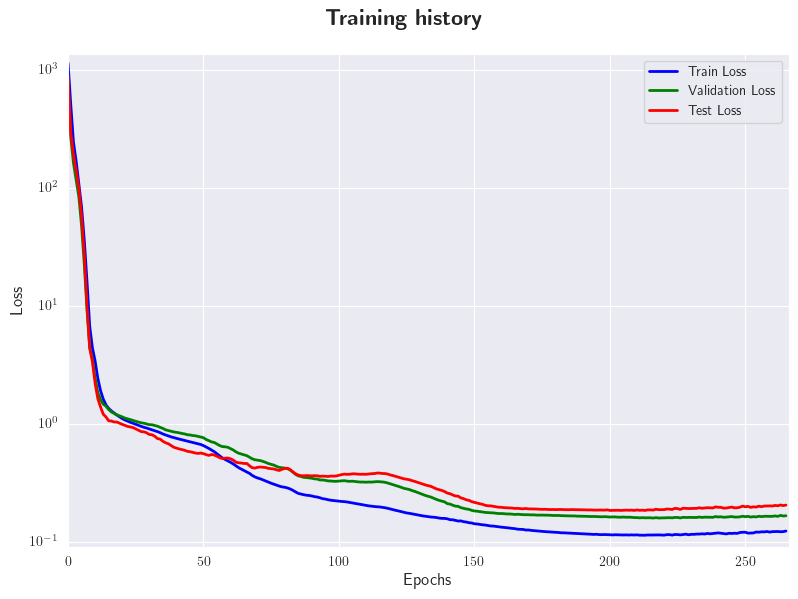

In [35]:
### Training process
%matplotlib qt
print('----- Training process -----')
save_path = os.path.join(result_dir, datetime.now().strftime("%H%M%S"))
Path(save_path).mkdir(parents=True, exist_ok=True)
        
model = NeuralNetwork().to(device)
model.hyperparameter_init(loss_func = nn.MSELoss(),
                          metric = [regression.MeanSquaredError().to(device)**(1/2),
                                    regression.MeanAbsolutePercentageError().to(device)*100,
                                    regression.R2Score().to(device)],
                          optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01))

model.history = {'train_loss': [], 'test_loss': [],
                 'val_loss': [], 'val_metric': [],
                 'train_metric': [], 'test_metric': []}
model.save_path = save_path

num_epochs = 1000
for epoch in range(num_epochs):
    # Train loop
    train_loss, train_metric = model.epoch_train(train_loader)
    model.history['train_loss'].append(train_loss); model.history['train_metric'].append(train_metric)

    # Validation loop
    val_loss, val_metric = model.epoch_test(val_loader)
    model.history['val_loss'].append(val_loss); model.history['val_metric'].append(val_metric)

    # Test loop
    test_loss, test_metric = model.epoch_test(test_loader)
    model.history['test_loss'].append(test_loss); model.history['test_metric'].append(test_metric)
    
    # Print epoch metrics
    print(f'> Epoch [{epoch+1:03}/{num_epochs:03}]:\n'
          f' > MSE Loss: Train: {train_loss:.3f}, Validation: {val_loss:.3f}, Test: {test_loss:.3f}\n'
          f' > RMSE Metric: Train: {train_metric[0]:.3f}, Validation: {val_metric[0]:.3f}, Test: {test_metric[0]:.3f}\n'
          f' > MAPE Metric: Train: {train_metric[1]:.3f}%, Validation: {val_metric[1]:.3f}%, Test: {test_metric[1]:.3f}%\n'
          f' > R2 Score: Train: {train_metric[2]:.3f}, Validation: {val_metric[2]:.3f}, Test: {test_metric[2]:.3f}')

    # Stop training and save model 
    if model.stop_condition(tol=1e-3, patience=50, num_epochs=num_epochs):
        best_loss = [model.best_history[key] for key in ['train_loss', 'val_loss', 'test_loss']]
        best_metric = [model.best_history[key] for key in ['train_metric', 'val_metric', 'test_metric']]

        print(f'> Model is saved at epoch {model.best_epoch+1:03}:\n'
              f' > MSE Loss: Train: {best_loss[0]:.3f}, Validation: {best_loss[1]:.3f}, Test: {best_loss[2]:.3f}\n'
              f' > RMSE Metric: Train: {best_metric[0][0]:.3f}, Validation: {best_metric[1][0]:.3f}, Test: {best_metric[2][0]:.3f}\n'
              f' > MAPE Metric: Train: {best_metric[0][1]:.3f}%, Validation: {best_metric[1][1]:.3f}%, Test: {best_metric[2][1]:.3f}%\n'
              f' > R2 Score: Train: {best_metric[0][2]:.3f}, Validation: {best_metric[1][2]:.3f}, Test: {best_metric[2][2]:.3f}')
        break

    # Plot loss
    model.plot_loss()

%matplotlib inline
plt.ioff()
plt.show()


In [36]:
### Save results
data_to_save = {
    'model': 'NeuralNetwork',
    # 'data_input': data_input_df,
    # 'data_output': data_output_df,
    # 'data_size': data_size,
    # 'batch_size': batch_size,
    'history': model.history,
    'best_epoch': model.best_epoch,
    'best_history': model.best_history,
    'save_path': model.save_path,
    # 'best_model_parameters': model.best_model,
    # 'best_optimizer_parameters': model.best_optimizer,
}

with open(os.path.join(save_path, 'Results.json'), 'w') as f:
    json.dump(data_to_save, f)
    
model.load_state_dict((torch.load(os.path.join(save_path, 'Best_model.pt'), weights_only=True)))
torch.save(model, os.path.join(save_path, 'Full_model.pt'))
print(save_path)


D:\tqkim\Python Run\B3E\Results\NN_Model\250129_170841\172126


In [37]:
### Load saved model
# load_path = os.path.join(script_dir, 'Results', current_file, '241101_161014', '161410')
load_path = save_path
model = torch.load(os.path.join(load_path, 'Full_model.pt'), map_location=device, weights_only=False)
model.load_state_dict((torch.load(os.path.join(load_path, 'Best_model.pt'), weights_only=True)))


<All keys matched successfully>

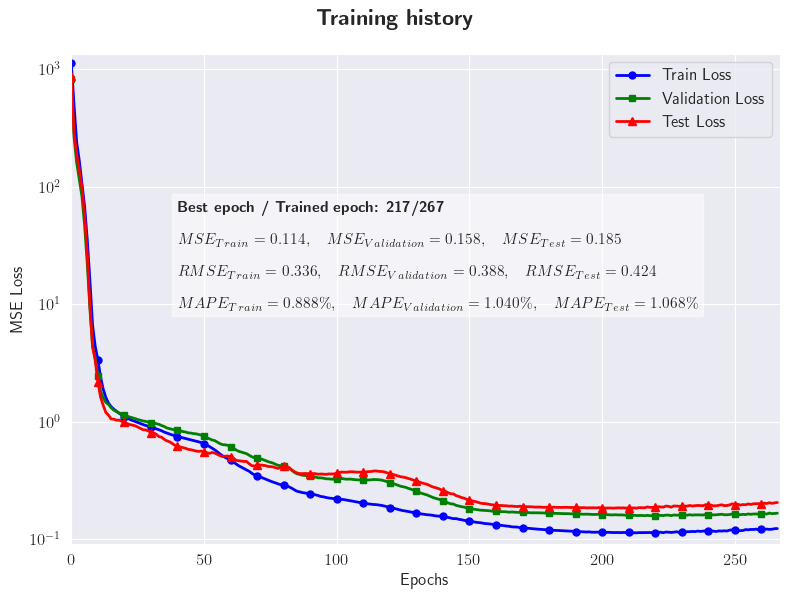

In [38]:
### Plot final training history
trained_epochs = range(model.max_epoch+1)
trained_history = {key: model.history[key][:model.max_epoch+1] for key in model.history.keys()}
best_loss = [model.best_history[key] for key in ['train_loss', 'val_loss', 'test_loss']]
best_metric = [model.best_history[key] for key in ['train_metric', 'val_metric', 'test_metric']]

plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(8, 6))
train_loss_line, = ax.plot(trained_epochs, trained_history["train_loss"],
                           label="Train Loss", color='b',
                           linestyle='-', linewidth=2, marker='o', ms=5, markevery=10)
val_loss_line, = ax.plot(trained_epochs, trained_history["val_loss"],
                         label="Validation Loss", color='g',
                         linestyle='-', linewidth=2, marker='s', ms=5, markevery=10)
test_loss_line, = ax.plot(trained_epochs, trained_history["test_loss"],
                          label="Test Loss", color='r',
                          linestyle='-', linewidth=2, marker='^', ms=6, markevery=10)
fig.suptitle(r'\textbf{Training history}', y=0.99, fontsize=16)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_xlim(0, model.max_epoch + 1)
ax.set_ylim(np.min([trained_history[key] for key in ["train_loss", "val_loss", "test_loss"]])*0.8,
            np.max([trained_history[key] for key in ["train_loss", "val_loss", "test_loss"]])*1.2)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=12)

ax.text(0.15, 0.70,
        r'\textbf{Best epoch / Trained epoch: ' + rf'{model.best_epoch+1:03}' + '/' + rf'{model.max_epoch+1:03}' + '}\n\n' +
        r'$MSE_{Train} = ' + rf'{best_loss[0]:.3f}' + r', \quad MSE_{Validation} = ' + rf'{best_loss[1]:.3f}' + r', \quad MSE_{Test} = ' + rf'{best_loss[2]:.3f}' + '$\n\n' +
        r'$RMSE_{Train} = ' + rf'{best_metric[0][0]:.3f}' + r', \quad RMSE_{Validation} = ' + rf'{best_metric[1][0]:.3f}' + r', \quad RMSE_{Test} = ' + rf'{best_metric[2][0]:.3f}' + '$\n\n' +
        r'$MAPE_{Train} = ' + rf'{best_metric[0][1]:.3f}\%' + r', \quad MAPE_{Validation} = ' + rf'{best_metric[1][1]:.3f}\%' + r', \quad MAPE_{Test} = ' + rf'{best_metric[2][1]:.3f}\%$',
        transform=ax.transAxes, fontsize=11,
        ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(save_path, 'Train_History.png'), dpi=400)
plt.show()


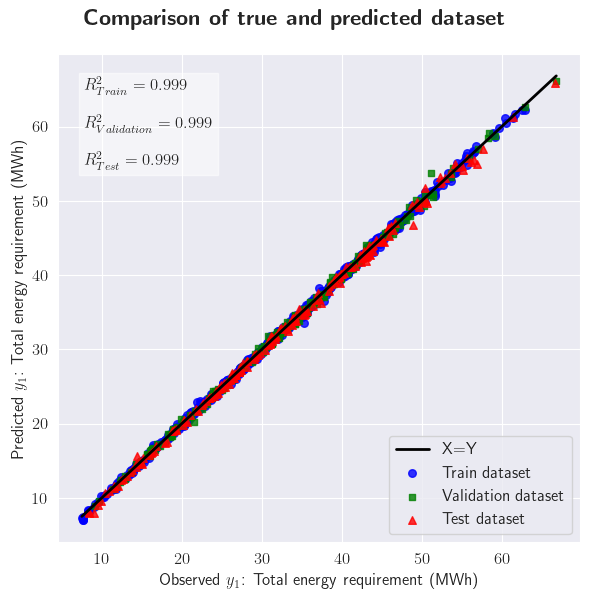

In [39]:
### Plot statistic comparison graph
train_output, train_pred, _, train_metric = model.predict(train_loader)
val_output, val_pred, _, val_metric = model.predict(val_loader)
test_output, test_pred, _, test_metric = model.predict(test_loader)

plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(6, 6))
y_x_line = ax.plot([min(data_output_df), max(data_output_df)], [min(data_output_df), max(data_output_df)], 
                   label='X=Y', color='k', linestyle='-', linewidth=2)
train_scatter = ax.scatter(train_output, train_pred, label='Train dataset', color='b', marker='o', s=30, alpha=0.8)
val_scatter = ax.scatter(val_output, val_pred, label='Validation dataset', color='g', marker='s', s=25, alpha=0.8)
test_scatter = ax.scatter(test_output, test_pred, label='Test dataset', color='r', marker='^', s=30, alpha=0.8)
   
fig.suptitle(r'\textbf{Comparison of true and predicted dataset}', y=0.99, fontsize=16)
ax.set_xlabel(r'Observed $y_{1}$: Total energy requirement (MWh)', fontsize=12)
ax.set_ylabel(r'Predicted $y_{1}$: Total energy requirement (MWh)', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.text(0.05, 0.95, 
        r'$R^{2}_{Train} = ' + rf'{train_metric[2]:.3f}$' + '\n\n' +
        r'$R^{2}_{Validation} = ' + rf'{val_metric[2]:.3f}$' + '\n\n' +
        r'$R^{2}_{Test} = ' + rf'{test_metric[2]:.3f}$',
        transform=ax.transAxes, fontsize=12, 
        ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))    
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(save_path, 'Statistics_Score.png'), dpi=400)
plt.show()
